In [1]:
import numpy as np
import pandas as pd
import h5py
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
import datetime
%matplotlib widget


# Load data
hf = h5py.File('geonet_f5.h5', 'r')
X = np.array(hf["X"])
Y = np.array(hf["Y"])
Z = np.array(hf["Z"])
lon = np.array(hf["lon"])
lat = np.array(hf["lat"])
hgt = np.array(hf["hgt"])
date = np.array(hf["date"]) # These include times
date = np.array(date, dtype='datetime64[D]') # Without times
name = hf["name"].asstr()[:] # Makes a numpy array of strings
offs = np.array(hf["offsets"])
# Calculate reference lon, lat for ENU conversion
lonmean = np.sum(lon, axis=1)/np.sum(lon !=0, axis=1)
latmean = np.sum(lat, axis=1)/np.sum(lat !=0, axis=1)


# Make offset array

In [2]:
def sph_distance(point1, point2):
    R = 6370
    lat1 = np.radians(point1[0])  #insert value
    lon1 = np.radians(point1[1])
    lat2 = np.radians(point2[0])
    lon2 = np.radians(point2[1])

    dlon = lon2 - lon1
    dlat = lat2- lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    return distance

In [3]:
# Load offsets 
offsets = pd.read_excel('f5/F3_offset_var221231.xlsx', 'Maintenance_list')
# Get rid of unparseable characters
offsets = offsets[offsets.month != "?"]
# Assemble date columns into datetime
offsets["date"] = pd.to_datetime(offsets[['year','month','day']])
# Reset index
offsets.reset_index(inplace=True, drop=True)

# Allocate space
offs = np.zeros_like(X, dtype=bool)
# For each offset, 
for i in range(len(offsets)):
    siteidx = np.where(name == str(offsets.loc[i, "site"])) # Station index
    dateidx = np.where(date == offsets.loc[i, "date"]) # Date index
    offs[siteidx, dateidx] = True # Set to True on day of offset

# Load earthquakes 
eq = pd.read_csv("japan_cmt_1996-2023_m6_d100.psvelomeca", sep="\s+")
# Calculate moment and moment magnitude
eq["mom"] = eq.sc*np.power(10, eq.iexp, dtype=np.float64)
eq["mag"] = (2/3)*(np.log10(eq.mom)-16.1)
# Distance threshold exponent
threshexp = np.array(0.36*eq.mag - 0.15)
threshdist = np.power(10, threshexp)
threshdist = np.repeat(threshdist, len(lonmean)).reshape(len(eq), len(lonmean)).T

# Distance between stations and earthquakes
eq_points = eq[["lat", "lon"]].values
sta_points = np.array([latmean, lonmean]).T
sta_eq_dist = cdist(sta_points, eq_points, sph_distance)
# Logical array indicating if there should be an earthquake jump
eqjump = np.less(sta_eq_dist, threshdist)
# Insert at correct dates
eqjumpdates = np.zeros_like(X, dtype=bool)

for i in range(len(eq)):
    # Parse dates from event name
    eqname = eq.loc[i, "name"]
    if len(eqname) == 13:
        eqdate = datetime.datetime.strptime(eqname[0:8], '%Y%m%d')
    else:
        eqdate = datetime.datetime.strptime(eqname[0:6], '%m%d%y')

    dateidx = np.where(date == np.array(eqdate, dtype='datetime64[D]'))[0] # Date index
    if len(dateidx) != 0:
        eqjumpdates[:, dateidx[0]] = eqjumpdates[:, dateidx[0]] + eqjump[:, i]

# Combine earthquakes with maintenance 
offs = offs + eqjumpdates
# Cumulative sum  
offs = np.cumsum(offs, axis=1)


In [4]:
testeq = np.array('2011-03-11', dtype='datetime64[D]')
print(np.where(date == testeq))
print(np.sum(eqjumpdates[:, 5468] > 0))


print(np.cumsum(offs, axis=1))


(array([5468]),)
1359
[[    0     0     0 ... 67179 67194 67209]
 [    0     0     0 ... 42886 42895 42904]
 [    0     0     0 ... 33998 34006 34014]
 ...
 [    0     0     0 ... 61010 61024 61038]
 [    0     0     0 ... 27279 27286 27293]
 [    0     0     0 ... 27321 27328 27335]]


In [5]:
def movingwindowidx(n, x=0):
    # Make a set of indices to define moving windows
    # The matrix, a, will be of size x-by-2*n+1
    # For example, to set a 60-day moving window for a position time series X, run
    # a, ac = movingwindowidx(30, np.shape(X)[1])
    # To calculate the average position within that window, use
    # meanX = np.sum(ac*X[i, a], axis=1)/np.sum(ac, axis=1)
    #
    # Set square matrix if no x specified
    if x == 0:
        x = 2*n + 1

    a1 = np.repeat(np.arange(0, x), 2*n+1).reshape((x, 2*n+1)) 
    a2 = np.repeat(np.arange(-n, n+1), x).reshape((2*n+1, x)).T
    a = a1 + a2
    a[a < 0] = -1
    a[a > x-1] = -1
    ac = a != -1 
    a[~ac] = 0
    return a, ac

In [6]:
def dsearchn(x, v):
    z=np.atleast_2d(x)-np.atleast_2d(v).T
    minv = np.abs(z).min(axis=0)
    idx = np.where(np.abs(z)==minv)
    idx = idx[0]
    return idx, minv

In [7]:
def xyz2enu(x, y, z, lon, lat):
    # Convert degrees to radians
    lon = np.deg2rad(lon)
    lat = np.deg2rad(lat)

    # Construct matrix components
    r11 = -np.sin(lat)*np.cos(lon)
    r12 = -np.sin(lat)*np.sin(lon)
    r13 = np.cos(lat)
    r21 = -np.sin(lon)
    r22 = np.cos(lon)
    r23 = 0
    r31 = np.cos(lat)*np.cos(lon)
    r32 = np.cos(lat)*np.sin(lon)
    r33 = np.sin(lat)

    # Do the conversion
    n = r11*x + r12*y + r13*z
    e = r21*x + r22*y + r23*z
    u = r31*x + r32*y + r33*z

    # Return outputs
    return e, n, u

# Calculate reference positions
### 60-day mean

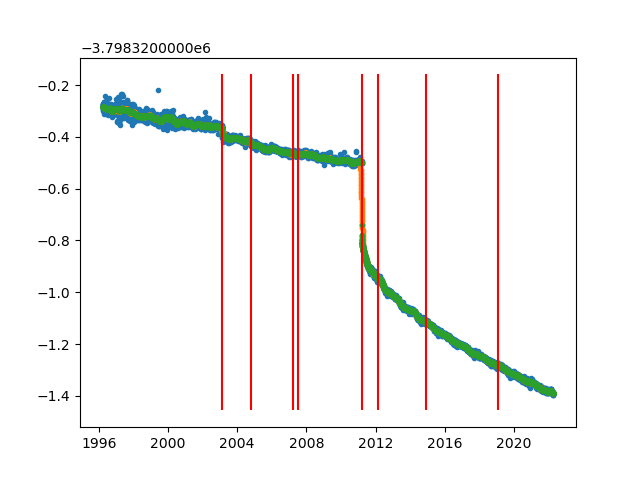

In [17]:
# Reference station mean positions
refsta = '950241'
refidx = np.where(name == refsta)[0]

# Get nominal date indices
velstart = np.datetime64('1994-01-01')
velend = np.datetime64('2022-04-09')
velstartidx = np.where(date == velstart)[0]
if len(velstartidx) == 0:
    velstartidx = 0
velendidx = np.where(date == velend)[0]
time_vec = np.arange(velstartidx, velendidx)

# Get indices and coefficients
a, ac = movingwindowidx(30, np.shape(X)[1])
# Calculate 60-day average positions of reference station

# Modify coefficients to ignore zero position days
ac[ac*X[refidx, a] == 0] = False
# Number of days used across this average
ndays = np.sum(ac, axis=1)
ndays[ndays==0] = 1
# Calculate mean positions
refXmean = np.sum(ac*X[refidx, a], axis=1)/ndays
refYmean = np.sum(ac*Y[refidx, a], axis=1)/ndays
refZmean = np.sum(ac*Z[refidx, a], axis=1)/ndays

# refXmedian = np.median(X[refidx, np.nonzero(X[refidx, a])], axis=1)
mx = np.ma.masked_where(X[refidx, a] == 0, X[refidx, a])
my = np.ma.masked_where(Y[refidx, a] == 0, Y[refidx, a])
mz = np.ma.masked_where(Z[refidx, a] == 0, Z[refidx, a]) 
refXmedian = np.ma.median(mx, axis=1).filled(0)
refYmedian = np.ma.median(my, axis=1).filled(0)
refZmedian = np.ma.median(mz, axis=1).filled(0)

refXmeanmean = np.mean(refXmean[refXmean != 0]) # mean of the means - the station's actual position
refYmeanmean = np.mean(refYmean[refYmean != 0]) 
refZmeanmean = np.mean(refZmean[refZmean != 0]) 

#    % Find indices of nonzero columns within time series bounds
#    nzIdx = sIdx - 1 + find(dates(i, sIdx:eIdx) > 0);
#    if ~isempty(nzIdx)
#       % Extract the data from those columns
#       t = dates(i, nzIdx);
#       lon(i) = mean(s.slon(i, nzIdx));
#       lat(i) = mean(s.slat(i, nzIdx));
#       hgt(i) = mean(s.shgt(i, nzIdx));
#       x = s.sx(i, nzIdx);
#       y = s.sy(i, nzIdx);
#       z = s.sz(i, nzIdx);
#       % Determine mean and standard deviation in time windows
#       a = movingavidx(tw, numel(nzIdx)); % get the indices of the moving average window elements
#       b = a; % make a copy
#       b(a == 0) = 1; % set all zeros to be ones; this array will be used for indexing
#       mx = (a > 0).*x(b); % use the zeros from a as coefficients
#       my = (a > 0).*y(b);
#       mz = (a > 0).*z(b);
#       meanrx = sum(mx)./sum(a > 0); % calculate the component means
#       meanry = sum(my)./sum(a > 0);
#       meanrz = sum(mz)./sum(a > 0);
#       % -------------------
#       % Velocities are zero
#       % -------------------
#       xest(i, nzIdx) = x; % calculate forward positions
#       yest(i, nzIdx) = y; 
#       zest(i, nzIdx) = z; 
#       tt(i, nzIdx) = t;
#       mnx0(nzIdx) = meanrx;
#       mny0(nzIdx) = meanry;
#       mnz0(nzIdx) = meanrz;
#       rx = mean(meanrx(meanrx ~= 0)); % mean of the means - the station's actual position
#       ry = mean(meanry(meanry ~= 0));
#       rz = mean(meanrz(meanrz ~= 0));
#       rnzIdx = nzIdx;


refnzidx = (X[refidx, :]!=0)[0]
fig, ax = plt.subplots()

ax.plot(date[refnzidx], X[refidx, refnzidx], '.')
ax.plot(date[refnzidx], refXmean[refnzidx], '.')
ax.plot(date[refnzidx], refXmedian[refnzidx], '.')
theseoffs = np.where(np.diff(offs[refidx[0], :]) != 0)
thesedates = date[theseoffs]
yl = ax.get_ylim()
ax.vlines(thesedates+1, yl[0], yl[1], color='r')
# ax.hlines(refXmeanmean, 1994, 2021)
plt.show()

# Calculate station velocities

In [18]:
plt.close('all')

# Indices of stations, excluding reference
stalist = np.setdiff1d(np.arange(0, np.shape(X)[0]), refidx)

corrposX = np.zeros_like(X)
corrposY = np.zeros_like(Y)
corrposZ = np.zeros_like(Z)

Xvar = np.zeros_like(X)
Yvar = np.zeros_like(X)
Zvar = np.zeros_like(X)

Xmedian = np.zeros_like(X)
Ymedian = np.zeros_like(X)
Zmedian = np.zeros_like(X)

Xpred = np.zeros_like(X)
Ypred = np.zeros_like(X)
Zpred = np.zeros_like(X)

E = np.zeros_like(X)
N = np.zeros_like(X)
U = np.zeros_like(X)

Evel = np.zeros(np.shape(X)[0])
Nvel = np.zeros(np.shape(X)[0])
Uvel = np.zeros(np.shape(X)[0])



# i = 583
for i in stalist:
    # Get indices and coefficients
    a, ac = movingwindowidx(30, np.shape(X)[1])
    # Calculate 60-day average positions of reference station

    # Modify coefficients to ignore zero position days
    ac[ac*X[i, a] == 0] = False
    # Number of days used across this average
    ndays = np.sum(ac, axis=1)
    ndays[ndays==0] = 1
    # Calculate mean positions
    Xwindow = ac*X[i, a]
    Ywindow = ac*Y[i, a]
    Zwindow = ac*Z[i, a]
    Xmean = np.sum(Xwindow, axis=1)/ndays
    Ymean = np.sum(Ywindow, axis=1)/ndays
    Zmean = np.sum(Zwindow, axis=1)/ndays
    # Variances as second moment about means
    repXmean = np.repeat(Xmean, np.shape(Xwindow)[1], axis=0).reshape(len(Xmean), np.shape(Xwindow)[1])
    repYmean = np.repeat(Ymean, np.shape(Ywindow)[1], axis=0).reshape(len(Ymean), np.shape(Ywindow)[1])
    repZmean = np.repeat(Zmean, np.shape(Zwindow)[1], axis=0).reshape(len(Zmean), np.shape(Zwindow)[1])
    Xvar[i, :] = np.sum(ac*(Xwindow - repXmean)**2, axis=1)/ndays
    Yvar[i, :] = np.sum(ac*(Ywindow - repYmean)**2, axis=1)/ndays
    Zvar[i, :] = np.sum(ac*(Zwindow - repZmean)**2, axis=1)/ndays
    # Standard deviations as square root of variances
    Xstd = np.sqrt(Xvar)
    Ystd = np.sqrt(Yvar)
    Zstd = np.sqrt(Zvar)
    # Median positions
    mx = np.ma.masked_where(X[i, a] == 0, X[i, a])
    my = np.ma.masked_where(Y[i, a] == 0, Y[i, a])
    mz = np.ma.masked_where(Z[i, a] == 0, Z[i, a]) 
    Xmedian[i, :] = np.ma.median(mx, axis=1).filled(0)
    Ymedian[i, :] = np.ma.median(my, axis=1).filled(0)
    Zmedian[i, :] = np.ma.median(mz, axis=1).filled(0)

    # Nonzero values within date range 
    nzidx = X[i, velstartidx:velendidx[0]] != 0
    # Column indices within date range
    useidx = np.arange(velstartidx, velendidx)
    # Nonzero column indices within date range
    useidx = useidx[nzidx]
    # # Mean position = Daily observation - Daily 60-day @ reference + Mean ref. position
    # meanposX = np.mean(X[i, useidx] - refXmedian[useidx] + refXmeanmean)
    # meanposY = np.mean(Y[i, useidx] - refYmedian[useidx] + refYmeanmean)
    # meanposZ = np.mean(Z[i, useidx] - refZmedian[useidx] + refZmeanmean)
    # # Corrected positions = Daily median - 60-day mean - Daily 60-day @ reference + Mean ref. position
    # corrposX[i, useidx] = Xmedian[i, useidx] - meanposX - refXmedian[useidx] + refXmeanmean
    # corrposY[i, useidx] = Ymedian[i, useidx] - meanposY - refYmedian[useidx] + refYmeanmean
    # corrposZ[i, useidx] = Zmedian[i, useidx] - meanposZ - refZmedian[useidx] + refZmeanmean

    # Mean position = Daily observation - Daily 60-day @ reference + Mean ref. position
    meanposX = np.mean(X[i, useidx])
    meanposY = np.mean(Y[i, useidx])
    meanposZ = np.mean(Z[i, useidx])
    # Corrected positions = Daily median - 60-day mean - Daily 60-day @ reference + Mean ref. position
    corrposX[i, useidx] = Xmedian[i, useidx] - meanposX 
    corrposY[i, useidx] = Ymedian[i, useidx] - meanposY 
    corrposZ[i, useidx] = Zmedian[i, useidx] - meanposZ 

    # Convert to ENU
    e, n, u = xyz2enu(corrposX[i, useidx], corrposY[i, useidx], corrposZ[i, useidx], lonmean[i], latmean[i])
    E[i, useidx] = e
    N[i, useidx] = n
    U[i, useidx] = u

    if useidx.size != 0: 

        # Estimate velocity within specified time window
        # Design matrix
        g = np.vstack((useidx, np.ones_like(useidx))).T
        # Component covariances
        xcov = np.linalg.inv(g.T*(1/Xvar[i,useidx])@g)
        ycov = np.linalg.inv(g.T*(1/Yvar[i,useidx])@g)
        zcov = np.linalg.inv(g.T*(1/Zvar[i,useidx])@g)
        # Estimated model parameters
        xmod = xcov@g.T*(1/Xvar[i,useidx])@E[i, useidx]
        ymod = ycov@g.T*(1/Yvar[i,useidx])@N[i, useidx]
        zmod = zcov@g.T*(1/Zvar[i,useidx])@U[i, useidx]
        # Extract velocities and convert to mm/yr
        Evel[i] = xmod[0]*365.25*1000
        Nvel[i] = ymod[0]*365.25*1000
        Uvel[i] = zmod[0]*365.25*1000

        # Predicted positions for comparison against observed
        Xpred[i, useidx] = g@xmod
        Ypred[i, useidx] = g@ymod
        Zpred[i, useidx] = g@zmod

# fig, ax = plt.subplots()
# ax.plot(date[useidx], corrposY[i, useidx], '.')
# fig, ax = plt.subplots()
# ax.plot(date[useidx], Y[i, useidx], '.')
# fig, ax = plt.subplots()
# ax.plot(date[useidx], E[i, useidx], '.')
# ax.plot(date[useidx], xpred, '.')
# plt.show()    

/var/folders/fg/yxk4m2b97gd8fx9whgk386y5szvp8k/T/ipykernel_56162/763659570.py:105: RuntimeWarning: divide by zero encountered in true_divide
  xcov = np.linalg.inv(g.T*(1/Xvar[i,useidx])@g)
/var/folders/fg/yxk4m2b97gd8fx9whgk386y5szvp8k/T/ipykernel_56162/763659570.py:106: RuntimeWarning: divide by zero encountered in true_divide
  ycov = np.linalg.inv(g.T*(1/Yvar[i,useidx])@g)
/var/folders/fg/yxk4m2b97gd8fx9whgk386y5szvp8k/T/ipykernel_56162/763659570.py:107: RuntimeWarning: divide by zero encountered in true_divide
  zcov = np.linalg.inv(g.T*(1/Zvar[i,useidx])@g)
/var/folders/fg/yxk4m2b97gd8fx9whgk386y5szvp8k/T/ipykernel_56162/763659570.py:109: RuntimeWarning: divide by zero encountered in true_divide
  xmod = xcov@g.T*(1/Xvar[i,useidx])@E[i, useidx]
/var/folders/fg/yxk4m2b97gd8fx9whgk386y5szvp8k/T/ipykernel_56162/763659570.py:110: RuntimeWarning: divide by zero encountered in true_divide
  ymod = ycov@g.T*(1/Yvar[i,useidx])@N[i, useidx]
/var/folders/fg/yxk4m2b97gd8fx9whgk386y5szvp8k/T

In [19]:
print(name.dtype)
# Save coordinates to file
hf = h5py.File("geonet_f5_median60_ENU_noref.h5", "w")
hf["eastpos"] = E
hf["northpos"] = N
hf["uppos"] = U
hf["eastunc"] = Xstd
hf["northunc"] = Ystd
hf["upunc"] = Zstd
hf["lon"] = lonmean
hf["lat"] = latmean
hf["date"] = date.astype(h5py.opaque_dtype(date.dtype))
hf["name"] = name
hf["offsets"] = offs
hf.close()

object


In [ ]:
datemat = np.repeat(date, [1430, 1], axis=0)

In [ ]:
fig, ax = plt.subplots()
vmag = np.sqrt(Evel**2 + Nvel**2)
Evel[np.abs(vmag) > 100] = 0
Nvel[np.abs(vmag) > 100] = 0
ax.quiver(lonmean, latmean, Evel, Nvel)
plt.show()

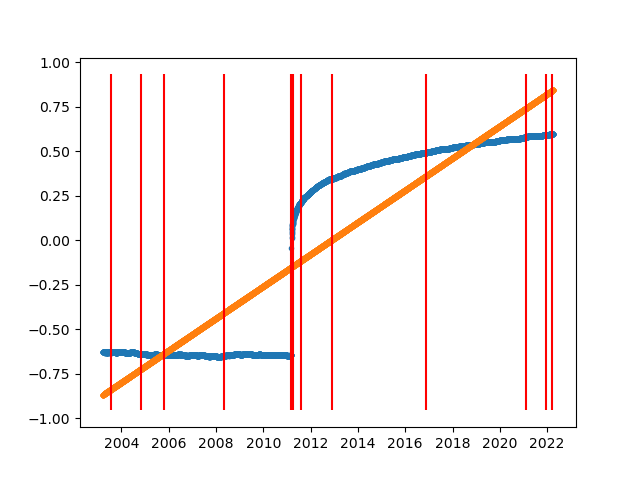

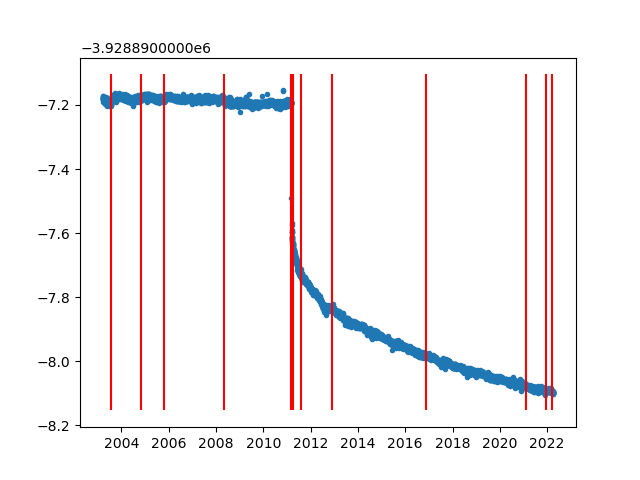

6.830766001494853e-06
[-3928897.1833 -3928897.181  -3928897.1728 ... -3928898.1    -3928898.0988
 -3928898.0979]


In [22]:
thissta = 112
# Nonzero values within date range 
nzidx = X[thissta, velstartidx:velendidx[0]] != 0
# Column indices within date range
useidx = np.arange(velstartidx, velendidx)
# Nonzero column indices within date range
useidx = useidx[nzidx]

fig, ax = plt.subplots()
ax.plot(date[useidx], E[thissta, useidx], '.')
ax.plot(date[useidx], Xpred[thissta, useidx], '.')
# 
theseoffs = np.where(np.diff(offs[thissta, :]) != 0)
thesedates = date[theseoffs]
yl = ax.get_ylim()
ax.vlines(thesedates+1, yl[0], yl[1], color='r')
plt.show()

fig, ax = plt.subplots()
ax.plot(date[useidx], X[thissta, useidx], '.')

yl = ax.get_ylim()
ax.vlines(thesedates+1, yl[0], yl[1], color='r')

# ax.plot(date[useidx], Xmedian[thissta, useidx], '.')

plt.show()

print(np.min(Xvar[thissta, useidx]))
print(X[thissta, useidx])
